# Guardian API and discussions

https://open-platform.theguardian.com/documentation/


I registered for a key which got marked as **spam** by Gmail :(.
I keep the key in a dictionnary in a Python module my_keys.


### Use

The API is quite easy to use with **requests**


So for the moment I haven't done much just basics : 
    
    
The q parameter supports AND, OR and NOT operators. 

### For example: 

debate AND economy 
(https://content.guardianapis.com/search?q=debate%20AND%20economy&tag=politics/politics&from-date=2014-01-01&api-key=test) 
returns only content that contains both "debate" and "economy".

debate AND NOT immigration (https://content.guardianapis.com/search?q=debate%20AND%20NOT%20immigration&tag=politics/politics&from-date=2014-01-01&api-key=test) returns only content that contains "debate" but does not contain "immigration".

The AND operator has a higher precedence than OR, but you can use parentheses to override this behavior. For example:

debate AND (economy OR immigration OR education) (https://content.guardianapis.com/search?q=debate%20AND%20(economy%20OR%20immigration%20education)&tag=politics/politics&from-date=2014-01-01&api-key=test) returns only content that contains both "debate" and and at least one of the following "economy", "immigration", "education".

Note that OR is the default operator, so you can omit it if you like. debate AND (economy immigration education) will behave the same as the above query.



In [95]:
import my_keys

key = my_keys.keys['guardian']

#https://gist.github.com/dannguyen/c9cb220093ee4c12b840

import re 
import requests
import pickle
from bs4 import BeautifulSoup
import json

In [1]:
from theguardian import theguardian_edition

# create edition
edition = theguardian_edition.Edition(api='test')

# get all results of a page
json_content = edition.get_content_response()
all_results = edition.get_results(json_content)

# get all the sections webUrl
for result in all_results:
    print("{id} - {url}" .format(id=result["id"], url=result["webUrl"]))

au - https://www.theguardian.com/au
international - https://www.theguardian.com/international
uk - https://www.theguardian.com/uk
us - https://www.theguardian.com/us


In [98]:
API_ENDPOINT = 'https://content.guardianapis.com/commentisfree/2019/mar/14/panic-maths-anxiety-studying-pupils-schools'

#API_ENDPOINT = 'https://content.guardianapis.com/tags'
#API_ENDPOINT = 'https://content.guardianapis.com/business/2014/feb/18/uk-inflation-falls-below-bank-england-target'

my_params = {
    #'show-blocks' : 'body:latest',
    'show-tags' : 'all',
    'api-key': my_keys.keys['guardian']
}

r = requests.get(API_ENDPOINT, my_params)


## Keywords & tags

These are buried away...

In [111]:
dd = json.loads(r.text) 
[x['id'] for x in dd['response']['content']['tags'] if x['type'] == 'keyword']


['education/mathematics',
 'education/education',
 'uk/uk',
 'education/schools',
 'education/primary-schools',
 'education/secondary-schools',
 'society/children']

Once you have a tag then it it is easy to pull related content using the API

In [27]:
API_ENDPOINT = 'https://content.guardianapis.com/search'

search_params = {
    'from-date': "2010-01-01",
    'to-date': "2019-01-01",
    'order-by': "newest",
    'show-fields': 'all',
    'page-size': 200,
    'tag' : 'education/mathematics',
    'api-key': key
}

r = requests.get(API_ENDPOINT, search_params)

dd = json.loads(r.text)
dd['response'].keys()

## Filtering the articles

So for maths there is

- a puzzle section edited by Alex Bellos
- obituaries

we'll skip these

In [45]:
stuff = [ x for x in dd['response']['results'] 
         if  'byline' in x['fields'] and x['fields']['byline'] != 'Alex Bellos']

stuff = [x for x in stuff if 'obituary' not in x['id']]

 I should use a default_dict for this

In [62]:
groups = {}

for x in stuff:
    author = x['fields']['byline']
    if author in groups:
        groups[author].append(x)
    else:
        groups[author] = [x]
        

In [64]:
for x,y in groups.items():
    print(x, len(y))

Richard Adams, Education editor 1
Kester Brewin 2
Richard Adams Education editor 8
Martin Belam 2
Letters 25
Simon Jenkins 2
Sarah Marsh 1
Simone Lia 1
Peter Bradshaw 1
Sally Weale Education correspondent 9
Rowena Mason 1
Michael Savage, Observer policy editor 1
Richard Adams 1
Grace Geilinger 1
Daniel Glaser 1
Howard Jacobson 1
Rowena Mason, Jessica Elgot and Rajeev Syal 1
Guardian music 1
Jon Butterworth 1
Emily McGovern 1
Marcus du Sautoy 2
Benjamin Haas in Hong Kong and Sally Weale 1
Nicola Davis 1
Christopher Knaus 1
Editorial 1
Richard Adams, Sally Weale, Helena Bengtsson and Severin Carrell 1
Johnny Martin 1
Richard Adams and Sally Weale 1
The Secret Teacher 1
Zofia Niemtus 3
Ian Sample Science editor 1
Chalkdust 1
Tim Gowers 1
Melissa Davey 1
Frances Perraudin 1
Esther Addley 1
Homa Khaleeli 1
Royal Statistical Society 2
David Klein 1
Haroon Siddique 1
Lynn Gamwell 1
Nick Gibb 1
Vicky Neale 1
Rupert Jones 1
Prathap Chandran 1
Peter Wilby 1
Richard Lea 1
Sarah Marsh and Zofia Ni

In [104]:
for y in groups['Nick Gibb']:
    print(y['webUrl'])
    #print( y['fields']['body'])

https://www.theguardian.com/commentisfree/2015/nov/26/maths-teachers-shanghai-china-uk


## The sad case of Simon Jenkins

He really hates math - we'll lift the comments

In [76]:
import re 
import requests
import pickle


#scrape the page and get the short url
short_url_pp =  re.compile('"shortUrlId":"(.*?)"')
article_url = 'https://www.theguardian.com/commentisfree/2019/mar/14/panic-maths-anxiety-studying-pupils-schools'

article_url = 'https://www.theguardian.com/commentisfree/2016/mar/10/fixation-maths-doesnt-add-up-targets'

r = requests.get(article_url)
mm = short_url_pp.search(r.text)
short_url = mm.group(1)

#the short url allows us to access the discussion
comments_url = 'https://api.nextgen.guardianapps.co.uk/discussion/%s.json'%short_url
params = {'orderBy' : 'newest',
          'pageSize' : 25,
          'displayThreaded' : 'true',
          'commentsClosed' : 'false',
          'page' : '',
          'maxResponses' : 3
         }

json_data =  []
start_page  = 1
last_page = None


for num_page in range(start_page, 10**4):
    print('getting comments page no.', num_page)
    params['page'] = num_page
    r = requests.get( comments_url, params=params)
    json_data.append( r.text)
    #The last page is a field in the json object
    #I don't need to read this as json I could do a regexp
    if num_page == start_page:
        json_dict = json.loads(r.text)
        last_page = json_dict['lastPage']
        print('there are %d pages'%last_page)
    if num_page == last_page : break
        

fn = '%s.pkl'%short_url.split('/')[-1]
print('archiving to %s'%fn)
with open(fn ,'wb') as fp:
    pickle.dump(json_data,fp)

getting comments page no. 1
there are 32 pages
getting comments page no. 2
getting comments page no. 3
getting comments page no. 4
getting comments page no. 5
getting comments page no. 6
getting comments page no. 7
getting comments page no. 8
getting comments page no. 9
getting comments page no. 10
getting comments page no. 11
getting comments page no. 12
getting comments page no. 13
getting comments page no. 14
getting comments page no. 15
getting comments page no. 16
getting comments page no. 17
getting comments page no. 18
getting comments page no. 19
getting comments page no. 20
getting comments page no. 21
getting comments page no. 22
getting comments page no. 23
getting comments page no. 24
getting comments page no. 25
getting comments page no. 26
getting comments page no. 27
getting comments page no. 28
getting comments page no. 29
getting comments page no. 30
getting comments page no. 31
getting comments page no. 32
archiving to 4he3x.pkl


In [78]:
from bs4 import BeautifulSoup

def html2comments(x):
    try:
        tt = json.loads(x)
    except:
        return ''
    
    soup = BeautifulSoup(tt['commentsHtml'])
    raw = [ comment.text for comment in  soup.findAll('div',  {'class' : "d-comment__body"}) ]
    return raw
    
all_texts = [ html2comments(page) for page in json_data[:] ]

from itertools import chain
all_comments = list(chain.from_iterable(all_texts))
    

In [86]:
print(''.join([x for x in all_comments if len(x) < 100]  ) )


Oh dear, off goes Simon on another math-phobic / science-phobic rant.

Some re-hashing of previous articles here too!

Well said.

A very beautiful post.

"of a stroke" --> "or a stroke"

GCSE physics seems to be having a good go at this!

Get rid of English Literature first. No subject could be a bigger waste of time than that.

.
You can't be applying very advanced economics.

They are where the money & power is.

His teacher's, or his teachers'?

.
You have a poor appreciation of both your child's knowledge and that of his teachers'.

Stupid article. Go live a world without maths and see how much you will miss it.

Oxbridge PPE rants at STEM - because THEY CAN'T DO IT!

.
That is not what Mr Jenkins was saying - which is why there are so many negative comments.

This is a repeat.

Indeed. Can one technically plagiarise themselves?


Can one technically plagiarise themselves?

Indeed, self-plagiarism is a recognised concept.

* Stefan Banach

Posted in error. This was meant to be a 

In [89]:
lengths = [(len(x),i) for i,x in enumerate(all_comments)]
lengths.sort()

In [90]:
lengths[-20:]

[(1866, 398),
 (1866, 1208),
 (1887, 548),
 (1917, 575),
 (1934, 812),
 (2012, 145),
 (2127, 174),
 (2150, 618),
 (2202, 1337),
 (2216, 248),
 (2331, 16),
 (2698, 274),
 (2700, 463),
 (2755, 342),
 (2918, 478),
 (4147, 36),
 (4183, 1199),
 (4955, 25),
 (4959, 21),
 (4960, 30)]

Calculate average length

In [93]:
x,y = zip(*lengths)
sum(x)/len(lengths)

388.78183069511357

In [132]:
_, refs = zip(*lengths[-55:-50])

sep = '-'*40 
some_txts = sep.join( all_comments[i] for i in refs )

(array([350., 363., 235., 156.,  97.,  73.,  47.,  39.,  19.,  19.,  15.,
          9.,   5.,   3.,   3.,   5.,   1.,   4.,   1.,   0.,   0.,   2.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([   5.   ,  128.875,  252.75 ,  376.625,  500.5  ,  624.375,
         748.25 ,  872.125,  996.   , 1119.875, 1243.75 , 1367.625,
        1491.5  , 1615.375, 1739.25 , 1863.125, 1987.   , 2110.875,
        2234.75 , 2358.625, 2482.5  , 2606.375, 2730.25 , 2854.125,
        2978.   , 3101.875, 3225.75 , 3349.625, 3473.5  , 3597.375,
        3721.25 , 3845.125, 3969.   , 4092.875, 4216.75 , 4340.625,
        4464.5  , 4588.375, 4712.25 , 4836.125, 4960.   ]),
 <a list of 40 Patch objects>)

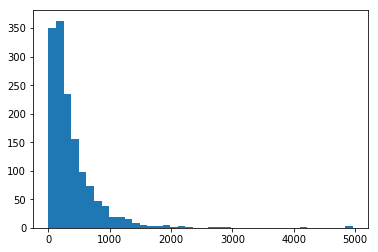

In [129]:
import matplotlib
import matplotlib.pyplot as plt
x,_ = zip(*lengths)
plt.hist(x, bins=40)

In [130]:
import textacy

In [134]:
doc = textacy.doc.Doc(some_txts)

In [135]:
stuff = list(textacy.extract.ngrams(doc, 
                            4, 
                            filter_stops=True, filter_punct=True, 
                            filter_nums=False))

In [136]:
def my_filter(x):
    pss = [token.pos_ for token in x]
    if u'\u2019s' in [token.orth_ for token in x]: return False
    if u'NOUN' in pss and not u'PROPN' in pss and u'PART' not in pss: return True
    return False
    
ngrams = [ x for x in stuff if my_filter(x)]
ngrams.sort( key=lambda x : x[0].lower_)     

In [142]:
[x for x in ngrams if 'math' in x.text.lower()]


[accepted that higher maths,
 actuality in maths education,
 Mathematics and logical thought,
 maths was without practical,
 maths in advanced physics,
 Maths should be elective,
 richer actuality in maths,
 world application of maths]

In [143]:
ngrams

['m a computer programmer,
 's no such thing,
 accepted that higher maths,
 actuality in maths education,
 advanced physics or writing,
 age is about giving,
 All these years later,
 ambushed by corporate capitalism,
 applicable to everyday life,
 applicable to the lives,
 average can I expect,
 beliefs you would find,
 block to a vast,
 calculus should be included,
 career they will want,
 children at year 7,
 children at that age,
 children have had good,
 choice when they're,
 come across the word,
 connected to practical life,
 country has a need,
 designers and creative thinkers,
 Do you expect children,
 educated widely knowledgeable public,
 education as an ideological,
 education at a young,
 enlightenment thinkers were far,
 fully understand the consequences,
 fully understanding the consequences,
 futility of the lottery,
 genealogy of this issue,
 geography on a daily,
 giving children the chance,
 great number of careers,
 guessing that the answer,
 head a different argumen